# Objectives

This notebooks visualize the result of sensor fusion algorithm applied on EuRoC MAV dataset.

A table and figures created in the notebook are used for the publication \link{}

In [28]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append('/app/src')

from src.internal.extended_common import (
    CoordinateFrame,
    Pose, State,
    ExtendedConfig,
    EUROC_SEQUENCE_MAPS
)
from src.common.datatypes import State, Pose
from src.internal.dataset import EuRoC_LeiCaDataReader, EuRoC_GroundTruthDataReader
from src.utils.geometric_transformer import GeometryTransformer, TransformationField

In [13]:
result_df = pd.read_csv("/app/outputs/EuRoC/specific_setups/results/euroc_experiment.csv", header=None)
result_df

,0,1,2,3,4,5,6,7,8,9,10
0,sequence,filter_type,motion_model,sensor,vo_estimation_type,mae,ate,rpe_m,rpe_deg,avg_inference_time_prediction_step,avg_inference_time_correction_step
1,01,ckf,velocity,vo_vel_leica,2d3d,0.08401172108743131,0.5257138251314047,0.0068971948930176595,0.09900518077602544,0.0006138332409279409,0.00038133151929682906


In [30]:
vo = pd.read_csv(
    "/app/outputs/vo_estimates/pose_estimates_2d3d_euroc_improved/absolute_pose/mav_01/data.csv",
    header=None).values.reshape(-1, 3, 4)


config = ExtendedConfig(config_filepath="/app/configs/euroc_config.yaml")
transformer = GeometryTransformer(config.hardware)
state = State(p=np.zeros((3, 1)), v=np.zeros((3, 1)), q=np.array([1, 0, 0, 0]).reshape(-1, 1), b_w=np.zeros((3, 1)), b_a=np.zeros((3, 1)))

vo_inertial = []
for _vo in vo:
    vo_i = transformer.transform(fields=TransformationField(
        state=state,
        value=_vo,
        coord_from=CoordinateFrame.STEREO_LEFT,
        coord_to=CoordinateFrame.INERTIAL,
    ))
    vo_inertial.append(vo_i.reshape(4, 4)[:3, 3].flatten())

vo_inertial = np.array(vo_inertial)
vo_inertial.shape

euroc_imu
euroc_leica
euroc_stereo
euroc_vo


(3681, 3)

In [19]:
sequence = '01'
drive = EUROC_SEQUENCE_MAPS.get(sequence, 'mav_01')

root_path = os.path.join('/app/data/EuRoC/', drive)

lecia = EuRoC_LeiCaDataReader(root_path=root_path)
gt = EuRoC_GroundTruthDataReader(root_path=root_path)

leica_data = iter(lecia)
lecia_inertial = []
for item in leica_data:
    z = np.array([item.p_x, item.p_y, item.p_z])
    lecia_inertial.append(z.flatten())

lecia_inertial = np.array(lecia_inertial)

gt_data = iter(gt)
gt_inertial = []
for item in gt_data:
    gt_inertial.append(item.p.flatten())

gt_inertial = np.array(gt_inertial)

Text(0, 0.5, 'Y [m]')

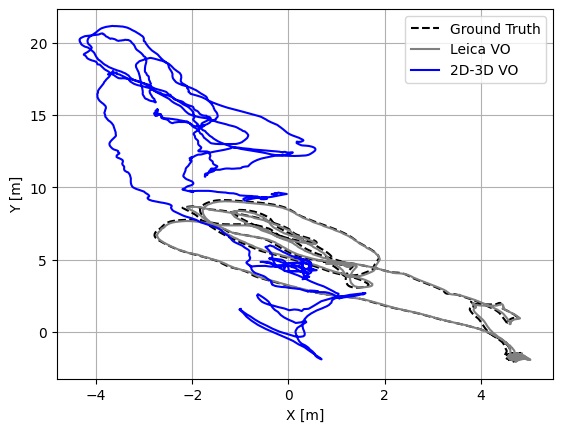

In [57]:
x_gt, y_gt = gt_inertial[:, 0], gt_inertial[:, 1]
plt.plot(x_gt, y_gt, label='Ground Truth', color='black', linestyle='--')
x, y = lecia_inertial[:, 0], lecia_inertial[:, 1]
plt.plot(x, y, label='Leica VO', color='gray')

x_vo, y_vo = vo_inertial[:, 0], vo_inertial[:, 2]
plt.plot(-x_vo, y_vo, label='2D-3D VO', color='blue')

plt.legend()
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
